# Email Marketing Campaign Analysis

# Conclusion (TLDR)

## Short, personalized emails sent M-TH have a CTR of ~3.48 percent, more than the overall CTR of ~2.12%. 

# Business Recommendation

## Assuming the cost of sending an email is zero, send the email to all users, but optimize for email characteristics that make it more likely that the user will click.

In [4]:
import numpy as np 
import pandas as pd
import seaborn as sns
sns.reset_defaults
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('ggplot')
font = {'size'   : 16}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook

In [5]:
from src.campaign_performance import qty_by_feature, pct_by_feature

In [6]:
df = pd.read_csv('data/joined_data.csv')

## Results of Email Campaign
Percentage of people who opened the email: 10.345%  
Percentage of people who clicked on the email: 2.119%

### Observations of Data

Caveat: these are initial obervations based on the data. Proper testing would be required to determine if these distinctions fall outside of the range of expected variance.

* US and UK users clicked at much higher rate. Consider if French and Spanish translations need to be improved.

* Shorter and more personalized emails led to higher CTRs.

* Users with greater past purchases tended to click more.

* Friday Saturday, and Sunday appear to be worst days to send the email.

## Numbers of Email Recipients / Recipients who Clicked

In [7]:
cols = ['email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases']

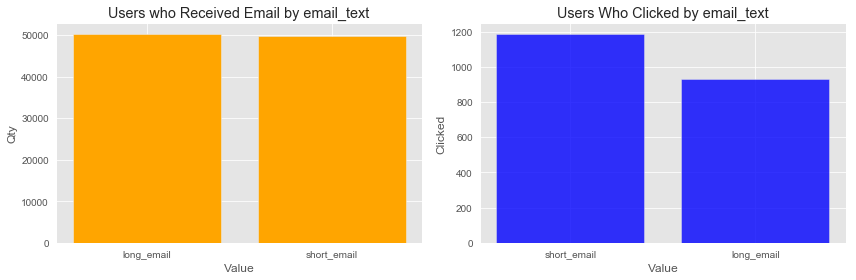

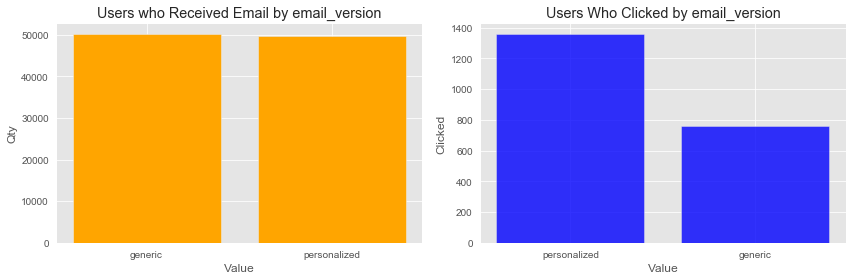

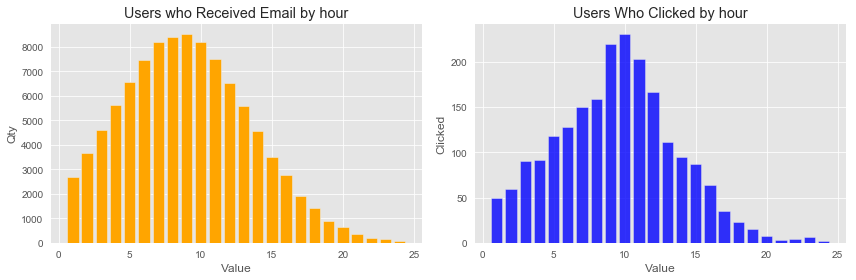

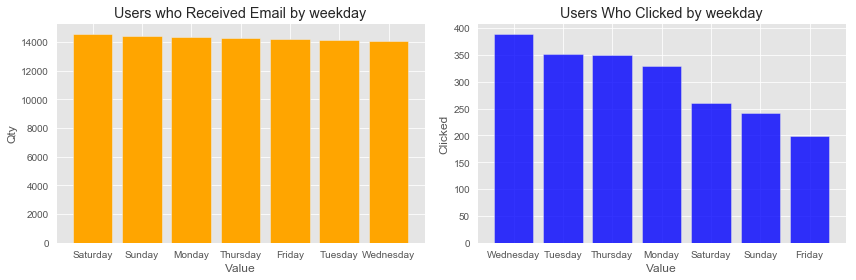

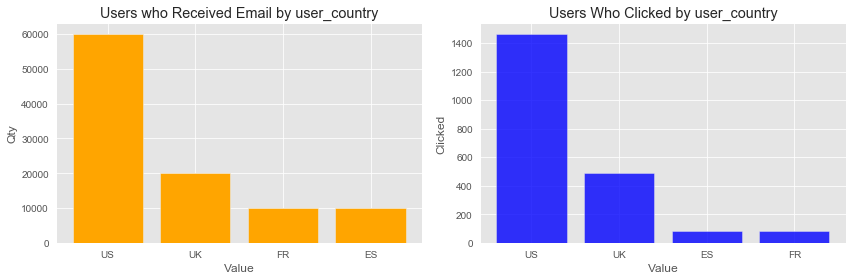

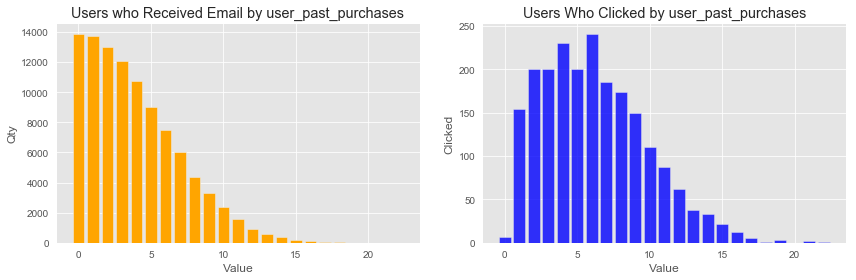

In [8]:
qty_by_feature(df, cols)

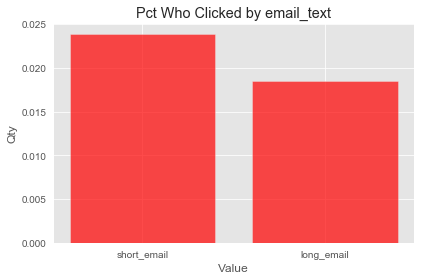

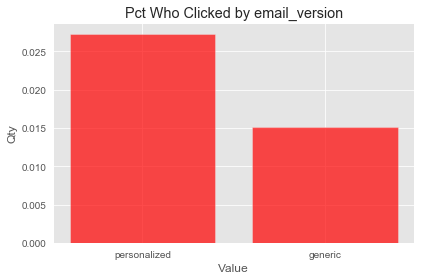

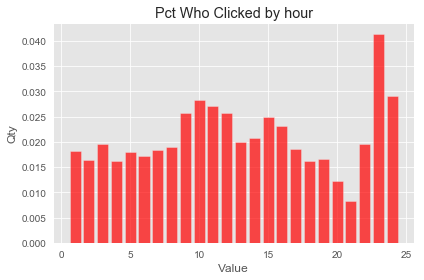

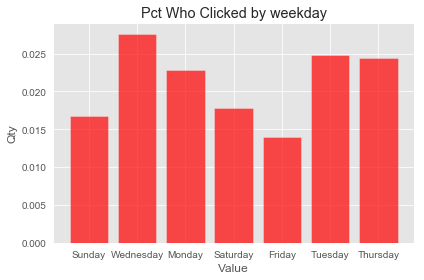

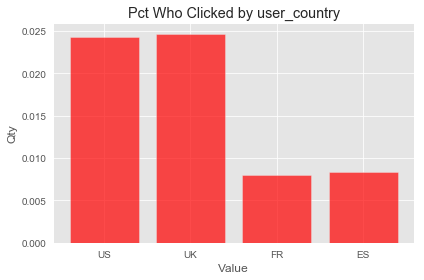

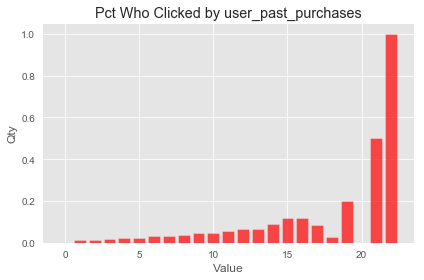

In [9]:
pct_by_feature(df, cols)

## Segemntation

Divide users into segments by characteristics of user: country, past purchases. Compare each of four email options for each segments.

In [11]:
df["user_past_purchases"].median() # divide purchases into two groups

3.0

In [ ]:
df[df["user_country"] == "US"] & df["user_past_purchases"] <= 3

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


## Are the differences observed above statistically significant?  

Perform a series of statistical tests to determine if differences are statistically signficant or just due to randomness.

In [59]:
    cols = ['email_text', 'email_version']
    for column in cols:
        counts = []
        obs = []
        for item in df[column].unique():
            counts.append(df[df[column] == item]['clicked'].sum())
            obs.append(df[df[column] == item].shape[0])
        stat, pval = proportions_ztest(counts, obs)
        print(column, pval)

email_text 4.738094975953786e-09
email_version 1.2295132171191242e-40


### Due to the p_values above, the differences in the CTR for email text and email version are statistically sigificant.

In [60]:
    multi_cols = ["user_country", "hour", "weekday", "user_past_purchases"]
    ctr = df["clicked"].sum() / df.shape[0] 
    for column in multi_cols:
        exp = []
        obs = []
        for item in df[column].unique():
            exp.append(df[df[column] == item].shape[0] * ctr)
            obs.append(df[df[column] == item]["clicked"].sum())
        chisq, p = chisquare(obs, exp, ddof=(len(df[column].unique()) - 1))
        print("{}: Chi Sq Stat {}, P_value {}".format(column, chisq, p))

user_country: Chi Sq Stat 199.758150229475, P_value nan
hour: Chi Sq Stat 87.9775687710944, P_value nan
weekday: Chi Sq Stat 101.04320606345784, P_value nan
user_past_purchases: Chi Sq Stat 1244.2272467789992, P_value nan


### Due to the p_values above, none of the multi-label variables fit a uniform distribution.  
### Translation: all of the observed differences are statistically significant

## Optimal Email Characteristics

In [14]:
opt_df = df[(df['email_text'] == "short_email") & (df['email_version'] == "personalized")]

In [15]:
op_df = opt_df[(opt_df['weekday'] == "Monday") | (opt_df['weekday'] == "Tuesday") | (opt_df['weekday'] == "Wednesday") | (opt_df['weekday'] == "Thursday")]

In [16]:
print("CTR with optimized email features: {}".format(op_df["clicked"].sum() / op_df.shape[0]))

CTR with optimized email features: 0.03484098939929329


In [17]:
top_2 = op_df[(op_df['user_country'] == "UK") | (op_df['user_country'] == "US")]
print("CTR with optimized email features in US and UK: {}".format(top_2["clicked"].sum() / top_2.shape[0]))

CTR with optimized email features in US and UK: 0.03967761934283943


# Conclusion

## Short, personalized emails sent M-TH have a CTR of ~3.48 percent, more than the overall CTR of ~2.12%. 

# Business Recommendation

## Assuming the cost of sending an email is zero, send the email to all users, but optimize for email characteristics that make it more likely that the user will click.

In [1]:
# Below is a test to determine of the data contains adaquately random sampling. 
# The target variable can be reset to determine if it is possible to predict sample class based on features.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, roc_curve, recall_score, classification_report
from imblearn.over_sampling import SMOTE

In [15]:
dt = DecisionTreeClassifier()

In [16]:
from model import Dummify

In [38]:
X = df.drop(["opened", "clicked", "user_country"], axis=1)
y = df["user_country"]

# define columns for one-hot encoding and merging back
drop_cols = ['email_text', 'email_version', 'weekday']
merge_cols = ['email_id', 'hour', 'user_past_purchases']

# dummify
d = Dummify(X, drop_cols, merge_cols)
d.get()
X = d.swap()

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,   random_state=42)

# smote
cols = X_train.columns
sm = SMOTE(random_state=66) # oversample minority class
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=X_train, columns=list(cols)) # return to dataframe


In [39]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
predictions = dt.predict(X_test)

In [41]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

         ES       0.10      0.14      0.12      3352
         FR       0.11      0.15      0.12      3299
         UK       0.20      0.22      0.21      6657
         US       0.60      0.50      0.54     19692

avg / total       0.42      0.37      0.39     33000

